# Library

In [8]:
%cd ~/github/liz.9.11.19_GMVLE/

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce

from utils.utils import read_vcf

/Users/maartenbiolizard/GitHub/liz.9.11.19_GMVLE


# Global variables

In [9]:
PATH_RAW = 'data/raw/'
PATH_INTERIM = 'data/interim/'
PATH_PROCESSED = 'data/processed/'
PATH_CONFIDENT_ROWS = "data/raw/HG003_GRCh38_1_22_v4.2.1_benchmark_noinconsistent.bed"

DIR_VCFEVAL = "data/vcfeval"

VC_DATA_NAME = "HG003_NA24149_Ashkenazim_father.trim"
BENCHMARK = "HG003_GRCh38_1_22_v4.2.1_benchmark"

CALLERS = ["dv", "fb", "oc", "st"] # DeepVariant, FreeBayes, Octopus, Strelka2

CONF = {
    "dv": {"y": "FILTER", "call": "PASS"},
    "fb": {"y": "ALT", "call": 'notna' },
    "oc": {"y": "FILTER", "call": "PASS"},
    "st": {"y": "FILTER", "call": "PASS"},
    "BM": {"y": "FILTER", "call": "PASS"},
    "keys": ["CHROM", "POS"],
    "features": ["QUAL", "DP"],
}

DTYPE = {"CHROM": pd.Int64Dtype(),
         "POS": int,
         "ID": str,
         "REF": str,
         "ALT": str,
         "QUAL": float,
         "FILTER": str,
         "INFO": str,
         "FORMAT": str,
         VC_DATA_NAME: str,
         "HG003": str,
         "DP": pd.Int64Dtype(),
         "REF_same": "boolean", 
         "DP_same": "boolean",
         "REF_BM": str,
         "ALT_BM": str, 
         "FILTER_BM": str
         }

# Load & standardise the data

In [3]:
def load_vcf_to_csv(callers = CALLERS, benchmark = BENCHMARK):
    for caller in callers:
        if not os.path.exists(PATH_INTERIM + caller + ".csv"):
            file_name = PATH_RAW + VC_DATA_NAME + "." + caller + ".vcf"
            data = read_vcf(file_name)
            data.to_csv(PATH_INTERIM + caller + ".csv", index=False)
            print(f"Saved {caller}.csv")
        else:
            print(f"{caller}.csv already exists")

    if not os.path.exists(PATH_INTERIM + benchmark + ".csv"):
        file_name = PATH_RAW + benchmark + ".vcf"
        benchmark_df = read_vcf(file_name)
        benchmark_df.to_csv(PATH_INTERIM + benchmark + ".csv", index=False)
        print(f"Saved {benchmark}")
    else:
        print(f"{benchmark} already exists")

load_vcf_to_csv()

dv.csv already exists
fb.csv already exists
oc.csv already exists
st.csv already exists
HG003_GRCh38_1_22_v4.2.1_benchmark already exists


In [4]:
def get_values_from_format(data: pd.DataFrame, format_column:str = "FORMAT", value_column:str = VC_DATA_NAME) -> pd.DataFrame:

    dict_error = {}

    # Assume that the FORMAT column is a string with the values separated by ":", and is the same for all rows
    # check if FORMAT column is unique
    if data[format_column].nunique() == 1:
        print("FORMAT column is unique")

        value_names = data[format_column].iloc[0].split(":")

        # split the value column by ":", and convert it to separate columns
        values = data[value_column].str.split(":", expand=True)
        values.columns = value_names

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = pd.concat([data, values], axis=1).copy()

    else:
        print("FORMAT column is not unique")

        # convert the format_column and value_column to a dict per row
        format_dict = {}

        for row in data.iterrows():
            
            # get row index and values
            index = row[0]

            values = row[1][value_column].split(":")
            cols = row[1]["FORMAT"].split(":")

            if len(values) != len(cols):
                # Different lengths at this row
                if row[1]["CHROM"] not in dict_error:
                    dict_error[row[1]["CHROM"]] = [row[1]["POS"]]
                else:
                    dict_error[row[1]["CHROM"]].append(row[1]["POS"])

                # add empty values to match the length of cols
                values += [np.nan] * (len(cols) - len(values))

            format_dict[index] = dict(zip(cols, values))

        # drop the original value column and concatenate the new columns
        data = data.drop(value_column, axis=1).drop(format_column, axis=1)
        data_new = data.merge(pd.DataFrame(format_dict).T, left_index=True, right_index=True).copy()

        print("Different lenght at CHROM: positions\n", dict_error)

    return data_new

## Merged variant calls

In [5]:
def process_vcf_data(callers = CALLERS, benchmark = BENCHMARK, dtype = DTYPE):

    cols_to_keep = ["CHROM", "POS", "REF", "ALT", "QUAL", "FILTER", # original columns
                    "DP", # "GT", "GQ" columns from FORMAT
                    ]

    for caller in callers:

        if not os.path.exists(PATH_PROCESSED + caller + ".csv"):
            print(f"Processing {caller}.csv")
            data = pd.read_csv(PATH_INTERIM + caller + ".csv", dtype=dtype, na_values=".")
            data_new = get_values_from_format(data)[cols_to_keep]
            data_new.to_csv(PATH_PROCESSED + caller + ".csv", index=False)
            display(data_new.head())

        else:
            print(f"{caller}.csv already processed")

    if not os.path.exists(PATH_PROCESSED + benchmark + ".csv"):
        print(f"Processing {benchmark}.csv")
        data = pd.read_csv(PATH_INTERIM + benchmark + ".csv", dtype=dtype, na_values=".")
        data_new = get_values_from_format(data, value_column="HG003")[cols_to_keep]

        # remove "chr" from CHROM column to match the other data
        data_new["CHROM"] = data_new["CHROM"].str.replace("chr", "")

        data_new.to_csv(PATH_PROCESSED + benchmark + ".csv", index=False)
        display(data_new.head())

    else:
        print(f"{benchmark}.csv already processed")

process_vcf_data()

dv.csv already processed
fb.csv already processed
oc.csv already processed
st.csv already processed
HG003_GRCh38_1_22_v4.2.1_benchmark.csv already processed


In [6]:
# Merge the dataframes on CHROM and POS
# Columns that are required to be the same in all dataframes: REF, DP
# Columns that are specific to the caller: ALT, QUAL, FILTER

def merge_dataframes(callers = CALLERS, on = ["CHROM", "POS"], same_col = ["REF", "DP"], dtype = DTYPE) -> pd.DataFrame:
    
    file_name = PATH_PROCESSED + "merged.csv"
    if not os.path.exists(file_name):
        print("Merging dataframes")

        dataframes = [pd.read_csv(PATH_PROCESSED + caller + ".csv", dtype=dtype) for caller in callers]

        # Create the merged dataframe
        for caller, df in zip(callers, dataframes):
            df.columns = [col + f"_{caller}" if col not in on else col for col in df.columns]

        df_merged = reduce(lambda left, right: pd.merge(left, right, on=on, how="outer"), dataframes)

        # Check if the data in the same columns is the same when it's not NaN

        for col in same_col:
            df_merged[f"{col}_same"] = df_merged[[f"{col}_{caller}" for caller in callers]].apply(lambda x: len(set(x.dropna())) == 1, axis=1)

        # Save the dataframe
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged dataframe already exists")
        df_merged = pd.read_csv(file_name)

    return df_merged

df_merged = merge_dataframes()
df_merged.head()

Merged dataframe already exists


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_20121/3053609022.py:29: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_merged = pd.read_csv(file_name)


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_oc,FILTER_oc,DP_oc,REF_st,ALT_st,QUAL_st,FILTER_st,DP_st,REF_same,DP_same
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,T,A,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,A,C,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True


## Merged variant calls + benchmark

In [31]:
def merge_benchmark(df_benchmark, df_merged, on=["CHROM", "POS"], dtype = DTYPE) -> pd.DataFrame:

    file_name = PATH_PROCESSED + "merged_benchmark.csv"
    if not os.path.exists(file_name):
        print("Merging benchmark")
        df_benchmark.columns = [col + "_BM" if col not in ["CHROM", "POS"] else col for col in df_benchmark.columns]

        # Select only the chromosomes that are in the benchmark
        chromosomes = df_benchmark["CHROM"].unique()
        df_merged = df_merged[df_merged["CHROM"].isin(chromosomes)]

        df_merged = pd.merge(df_merged, df_benchmark, on=on, how="outer")
        df_merged.to_csv(file_name, index=False)

    else:
        print("Merged benchmark already exists")
        df_merged = pd.read_csv(file_name, dtype=dtype)

    # print the number of rows per chromosome
    # print("Number of rows per chromosome")
    #display(df_merged["CHROM"].value_counts().sort_index())

    return df_merged

df_benchmark = pd.read_csv(PATH_PROCESSED + BENCHMARK + ".csv")
df_merged_BM = merge_benchmark(df_benchmark, df_merged)
df_merged_BM.head()

Merged benchmark already exists


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,QUAL_st,FILTER_st,DP_st,REF_same,DP_same,REF_BM,ALT_BM,QUAL_BM,FILTER_BM,DP_BM
0,1,10103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,12.0,True,True,NaN,NaN,NaN,NaN,NaN
1,1,10105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,LowGQX;NoPassedVariantGTs,16.0,True,True,NaN,NaN,NaN,NaN,NaN
2,1,10120,T,C,0.0,RefCall,127.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
3,1,10126,T,C,0.0,RefCall,116.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN
4,1,10132,T,C,0.0,RefCall,102.0,NaN,NaN,NaN,...,NaN,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN


## Merged variant calls + benchmark: High confidence

### Confidence regions

In [32]:
# chromStart is inclusive (first = 0), chromEnd is exclusive (https://en.wikipedia.org/wiki/BED_(file_format))

def read_conf_regions(file_name: str) -> pd.DataFrame:

    confidence_regions = pd.read_csv(file_name, sep="\t", header=None, names=["CHROM", "START", "END"])
    confidence_regions["CHROM"] = confidence_regions["CHROM"].str.replace("chr", "")

    # convert chrom to int
    confidence_regions["CHROM"] = confidence_regions["CHROM"].astype(int)

    return confidence_regions

In [33]:
def select_confident_regions(df, confidence_regions, name, dtype = DTYPE) -> pd.DataFrame:

    file_name = PATH_PROCESSED + f"{name}.csv"

    if not os.path.exists(file_name):

        print(f"Selecting confident regions for {name}")
            
        # Initialize CONFIDENCE column with False
        df["CONFIDENCE"] = False

        # Loop over confidence regions in a vectorized way
        for _, region in confidence_regions.iterrows():
            mask = (df["CHROM"] == region["CHROM"]) & df["POS"].between(region["START"], region["END"] - 1)
            df.loc[mask, "CONFIDENCE"] = True

        df_conf = df[df["CONFIDENCE"]]

        print(f"Number of rows in confidence regions: {df['CONFIDENCE'].sum()} / {len(df)} ({df['CONFIDENCE'].sum() / len(df) * 100:.2f}%)")

        df_conf.to_csv(file_name, index=False)
    
    else:
        print(f"{file_name} already exists")
        df_conf = pd.read_csv(file_name, dtype=dtype)

    return df_conf

In [34]:
confidence_regions = read_conf_regions(PATH_CONFIDENT_ROWS)
df_merged_BM = merge_benchmark(df_benchmark, df_merged)

df_merged_BM_confident = select_confident_regions(df_merged_BM, confidence_regions, name="merged_benchmark_confident")
df_merged_BM_confident.head()

Merged benchmark already exists
data/processed/merged_benchmark_confident.csv already exists


,CHROM,POS,REF_dv,ALT_dv,QUAL_dv,FILTER_dv,DP_dv,REF_fb,ALT_fb,QUAL_fb,...,FILTER_st,DP_st,REF_same,DP_same,REF_BM,ALT_BM,QUAL_BM,FILTER_BM,DP_BM,CONFIDENCE
0,1,601544,G,A,0.4,RefCall,42.0,G,A,31.6346,...,PASS,40.0,True,False,NaN,NaN,NaN,NaN,NaN,True
1,1,601606,G,T,0.1,RefCall,42.0,NaN,NaN,NaN,...,PASS,39.0,True,False,NaN,NaN,NaN,NaN,NaN,True
2,1,601673,G,A,0.1,RefCall,46.0,NaN,NaN,NaN,...,NaN,NaN,True,True,NaN,NaN,NaN,NaN,NaN,True
3,1,601811,C,G,0.4,RefCall,41.0,C,G,65.2423,...,PASS,38.0,True,False,NaN,NaN,NaN,NaN,NaN,True
4,1,601890,C,T,1.2,RefCall,33.0,C,T,140.8790,...,PASS,30.0,True,False,NaN,NaN,NaN,NaN,NaN,True


## Metric definitions

In [42]:
def label_caller_data(df_merged_BM, conf = CONF, callers = CALLERS, benchmark_abbr = "BM", how = "all", features = [], BM_features = []) -> pd.DataFrame:

    assert type(callers) == list, "callers must be a list"

    methods = callers + [benchmark_abbr]

    callers_cols = [f"{conf[method]['y']}_{method}" for method in callers]
    methods_cols = [f"{conf[method]['y']}_{method}" for method in methods]
    features_cols = [f"{feature}_{caller}" for feature in features for caller in callers] + [f"{feature}_{benchmark_abbr}" for feature in BM_features]

    df_call = df_merged_BM.copy()[conf["keys"] + methods_cols + features_cols].set_index(conf["keys"])

    # drop rows with nan values in all columns
    df_call.dropna(axis = 0, how="all", inplace=True, subset=methods_cols)

    # assign the boolean labels to the data based on the call configuration
    for method in methods:
        y = conf[method]["y"]
        call = conf[method]["call"]

        if call == "notna":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"].notna()
        elif call == "PASS":
            df_call[f"{y}_{method}"] = df_call[f"{y}_{method}"] == "PASS"
        else:
            print("Invalid call:", call)
    
    # rename prediction to y_hat: if there are multiple callers, create a consensus column
    if how == "all":
        df_call["y_hat"] = df_call[callers_cols].all(axis=1)
    elif how == "majority":
        df_call["y_hat"] = df_call[callers_cols].sum(axis=1) > len(callers) / 2
    elif how == "any":
        df_call["y_hat"] = df_call[callers_cols].any(axis=1)
    elif how == "per_caller":
        for caller in callers:
            df_call[f"y_hat_{caller}"] = df_call[f"{conf[caller]['y']}_{caller}"]


    # rename the benchmark column to y
    df_call["y"] = df_call[f"{conf[benchmark_abbr]['y']}_{benchmark_abbr}"]

    if how == "per_caller":
        df_call = df_call[[f"y_hat_{caller}" for caller in callers] + ["y"] + features_cols]
    
    else:
        # keep only the benchmark column (true call) and the predicted column (y_hat)
        df_call = df_call[["y", "y_hat"] + features_cols]

    return df_call
        

def calculate_performance(df_call, callers: list, true_label:str = "y", pred:str = "y_hat"):

    print(f"Calculating performance metrics for {callers}")

    caller_bool = df_call[pred]
    benchmark_bool = df_call[true_label]

    # True Positives (TP)
    TP = (caller_bool & benchmark_bool)
    
    # False Positives (FP)
    FP = (caller_bool & ~benchmark_bool)
    
    # False Negatives (FN)
    FN = (~caller_bool & benchmark_bool)

    # True Negatives (TN) are not applicable: the benchmark only contains the positive cases

    # Performance metrics
    TP_count = TP.sum()
    FP_count = FP.sum()
    FN_count = FN.sum()

    precision = TP_count / (TP_count + FP_count)
    recall = TP_count / (FN_count + TP_count)
    F1 = 2 * precision * recall / (precision + recall)

    TP_baseline = benchmark_bool.sum()

    # create a dictionary with the performance metrics

    performance = {
        "True-pos-baseline": TP_baseline,
        "True-pos-call": TP_count,
        "False-pos": FP_count,
        "False-neg": FN_count,
        "Precision": round(precision, 4),
        "Sensitivity": round(recall, 4),
        "F-measure": round(F1, 4),
    }

    return performance

------------------------------------------------------------------------------------------------

# Perfomance metrics

In [36]:
from collections import defaultdict

def get_custom_performance(df_name, conf, callers: list, index = None):
    id_dict = {"DATA": "None", "CALLER": "None", "METHOD": "None", "METRICS": "custom"}

    list_of_dfs = []

    df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

    for caller in callers:
        id = id_dict.copy()
        id.update({"CALLER": caller})

        df_call = label_caller_data(df_VC_BM, conf, [caller])

        if index is not None:
            if "confident" in df_name:
                id.update({"DATA": "selection_confident"})
            
            else:
                id.update({"DATA": "selection"})

            print(f"Selecting based on index: {len(index)} / {len(df_call)}")
            performance = calculate_performance(df_call.loc[df_call.index.isin(index)], [caller])
        
        else:
            if "confident" in df_name:
                id.update({"DATA": "confident"})
            
            else:
                id.update({"DATA": "all"})
        
            performance = calculate_performance(df_call, [caller])

        multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())

        # add performance metrics as a df row to the table
        list_of_dfs.append(pd.DataFrame(performance, index=multi_id))

    for how in ["all", "majority", "any"]:
        id = id_dict.copy()
        id.update({"CALLER": ", ".join(callers)})
        id.update({"METHOD": how})

        df_call = label_caller_data(df_VC_BM, conf, callers, how=how)

        if index is not None:
            if "confident" in df_name:
                id.update({"DATA": "selection_confident"})
            
            else:
                id.update({"DATA": "selection"})

            print(f"Selecting based on index: {len(index)} / {len(df_call)}")
            performance = calculate_performance(df_call.loc[df_call.index.isin(index)], callers)
        
        else:
            if "confident" in df_name:
                id.update({"DATA": "confident"})
                performance = calculate_performance(df_call, callers)

            else:
                id.update({"DATA": "all"})
                performance = calculate_performance(df_call, callers)

        multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())

        # add performance metrics as a df row to the table
        list_of_dfs.append(pd.DataFrame(performance, index=multi_id))

    # create a table with the performance metrics
    df_performance = pd.concat(list_of_dfs, axis=0)

    return df_performance


def get_vcfeval_performance(callers: list, experiment: str, DIR_VCFEVAL: str):

    id_dict = {"DATA": "None", "CALLER": "None", "METHOD": "None", "METRICS": "vcfeval"}
    
    if "noinconsistent" in experiment:
        id_dict["DATA"] = "confident"
    else:
        id_dict["DATA"] = "all"

    list_of_dfs = []
    
    for caller in callers:
        id = id_dict.copy()
        id.update({"CALLER": caller})

        # get the summary file
        file_name = f"{DIR_VCFEVAL}/vcfeval_{caller}_{experiment}/summary.txt"

        # print the summary
        with open(file_name, "r") as file:
            lines = file.readlines()
            
            # drop line with '---'
            lines = [line for line in lines if not line.startswith("---")]
            print(f"Summary for {caller}")
            
            # put lines in a table
            table = [line.split() for line in lines]
            df = pd.DataFrame(table[1:], columns=table[0])

            # keep only threshold == None
            df = df[df["Threshold"] == "None"]

            multi_id = pd.MultiIndex.from_tuples([tuple(id.values())], names=id.keys())
            df.index = multi_id

            list_of_dfs.append(df)
    
    # create a table with the performance metrics
    df_performance = pd.concat(list_of_dfs, axis=0)

    return df_performance


def create_performance_table(df_name, experiment: str, index = None, conf = CONF, callers = CALLERS, DIR_VCFEVAL = DIR_VCFEVAL):

    # If there is an index specified, omit the vcfeval performance, because it's based on all the data
    # Table index should be:
    # DATA: all/confident; 
    # CALLER: st, oc, fb, dv; 
    # METHOD: None, all, majority, any, XGB, RF; 
    # METRICS: vcfeval, custom]

    if index is not None:

        df_custom_performance = get_custom_performance(df_name, conf, callers, index)
        df_performance = df_custom_performance

    else:
        df_custom_performance = get_custom_performance(df_name, conf, callers)
        df_vcfeval_performance = get_vcfeval_performance(callers, experiment, DIR_VCFEVAL)
        
        # concat 
        df_performance = pd.concat([df_custom_performance, df_vcfeval_performance])

    return df_performance

In [37]:
df_performance_list = []

for experiment, df_name, selection in zip(["withoutseq_qual", "noinconsistent_withoutseq_qual"],
                          ["merged_benchmark", "merged_benchmark_confident"], 
                          ["ALL DATA", "ONLY CONFIDENT REGIONS"]):
    
    print(f"Performance for {selection}")
    
    df_performance = create_performance_table(df_name, experiment)
    df_performance_list.append(df_performance)

caller_order = ["dv", "fb", "oc", "st", "dv, fb, oc, st"]
df_performance = pd.concat(df_performance_list).reindex(caller_order, level="CALLER")
df_performance

Performance for ALL DATA
Calculating performance metrics for ['dv']
Calculating performance metrics for ['fb']
Calculating performance metrics for ['oc']
Calculating performance metrics for ['st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Summary for dv
Summary for fb
Summary for oc
Summary for st
Performance for ONLY CONFIDENT REGIONS
Calculating performance metrics for ['dv']
Calculating performance metrics for ['fb']
Calculating performance metrics for ['oc']
Calculating performance metrics for ['st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Summary for dv
Summary for fb
Summary for oc
Summary for st


True-pos-baseline True-pos-call  \
DATA      CALLER         METHOD   METRICS                                   
all       dv             None     custom            4005201       3972233   
                                  vcfeval           3962239       3963155   
          fb             None     custom            4005201       3873139   
                                  vcfeval           3915360       3833593   
          oc             None     custom            4005201       3947129   
                                  vcfeval           3948638       3982730   
          st             None     custom            4005201       3952864   
                                  vcfeval           3945375       3947418   
          dv, fb, oc, st all      custom            4005201       3834073   
                         majority custom            4005201       3954885   
                         any      custom            4005201       3982791   
confident dv             None     custom            3833766       3810160   
                                  vcfeval           3805802       3806289   
          fb             None     custom            3833766       3729882   
                                  vcfeval           3779803       3706627   
          oc             None     custom            3833766       3792641   
                                  vcfeval           3797292       3825636   
          st             None     custom            3833766       3798657   
                                  vcfeval           3796035       3797248   
          dv, fb, oc, st all      custom            3833766       3701225   
                         majority custom            3833766       3801100   
                         any      custom            3833766       3816765   

                                          False-pos False-neg Precision  \
DATA      CALLER         METHOD   METRICS                                 
all       dv             None     custom     732942     32968    0.8442   
                                  vcfeval    809557     37821    0.8304   
          fb             None     custom    1163685    132062     0.769   
                                  vcfeval   1202574     84700    0.7612   
          oc             None     custom     737402     58072    0.8426   
                                  vcfeval    814979     51416    0.8301   
          st             None     custom     617727     52337    0.8648   
                                  vcfeval    695789     54685    0.8501   
          dv, fb, oc, st all      custom     374470    171128     0.911   
                         majority custom     573154     50316    0.8734   
                         any      custom    1486166     22410    0.7283   
confident dv             None     custom      25005     23606    0.9935   
                                  vcfeval      5695     26113    0.9985   
          fb             None     custom     103023    103884    0.9731   
                                  vcfeval     85622     52112    0.9774   
          oc             None     custom      50575     41125    0.9868   
                                  vcfeval     16516     34623    0.9957   
          st             None     custom      31476     35109    0.9918   
                                  vcfeval     11657     35880    0.9969   
          dv, fb, oc, st all      custom      19477    132541    0.9948   
                         majority custom      25550     32666    0.9933   
                         any      custom     127741     17001    0.9676   

                                          Sensitivity F-measure Threshold  
DATA      CALLER         METHOD   METRICS                                  
all       dv             None     custom       0.9918    0.9121       NaN  
                                  vcfeval      0.9905    0.9034      None  
          fb             None     custom        0.967    0.8567       NaN  
            

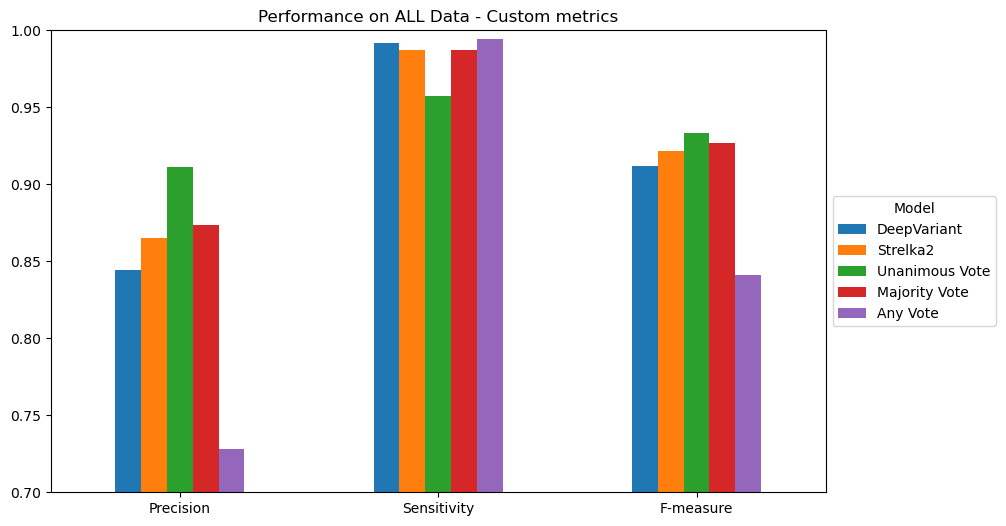

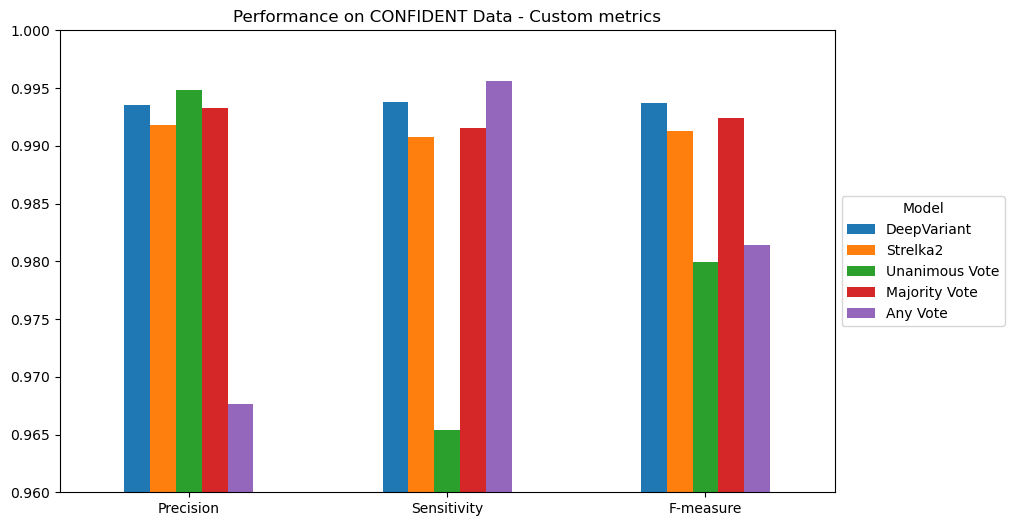

In [38]:
for data_sel, y_low in zip(["all", "confident"], [0.70, 0.96]):

    temp = df_performance.loc[(data_sel, slice(None), slice(None), "custom"), ["Precision", "Sensitivity", "F-measure"]].astype(float)

    # drop Octopus and FreeBayes

    temp = temp.drop(["oc", "fb"], level="CALLER")

    #drop DATA and METRICS columns
    temp = temp.droplevel(["DATA", "METRICS"], axis=0).transpose()

    temp.astype(float).plot(kind="bar", title=f"Performance on {data_sel.upper()} Data - Custom metrics", figsize=(10, 6))

    # rename legend labels
    plt.legend(title="Model", 
                labels=["DeepVariant", "Strelka2", "Unanimous Vote", "Majority Vote", "Any Vote"],
                loc="center left", bbox_to_anchor=(1, 0.5))
    plt.ylim(y_low, 1)

    # turn x lables 45 degrees
    plt.xticks(rotation=0)





# ML Classifiers

## Load the data

In [ ]:
def get_X_y(df_VC_BM, conf = CONF, callers = CALLERS, how = "per_caller", features=["QUAL", "DP"]):

    df_call = label_caller_data(df_VC_BM, conf, callers=callers, how=how, features=features)

    y = df_call["y"]
    X = df_call.drop("y", axis=1)

    return X, y

## Split the data into training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split

def select_data(X, y, chrom = None) -> tuple:

    if chrom is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    else:
        X_chrom = X.loc[X.index.get_level_values("CHROM") == chrom]
        y_chrom = y.loc[y.index.get_level_values("CHROM") == chrom]

        X_train, X_test, y_train, y_test = train_test_split(X_chrom, y_chrom, test_size=0.2, random_state=42)

    # print the amount of positive and negative cases in the training and test sets
    print("Training set")
    print(y_train.value_counts())
    print("Test set")
    print(y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

## Preprocess the data

In [ ]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(X_train, X_test, callers = CALLERS):
    
    # convert boolean columns to integers
    for col in X_train.columns:
        if X_train[col].dtype == bool:
            X_train[col] = X_train[col].astype(int)
            X_test[col] = X_test[col].astype(int)

    # fill QUAL with min value of the caller
    for caller in callers:
        minimal_qual = X_train[f"QUAL_{caller}"].min()

        X_train[f"QUAL_{caller}"] = X_train[f"QUAL_{caller}"].fillna(minimal_qual)
        X_test[f"QUAL_{caller}"] = X_test[f"QUAL_{caller}"].fillna(minimal_qual)

    # fill DP with the median value of all callers
    median_DP_train = X_train[[f"DP_{caller}" for caller in callers]].median(axis = 1)
    median_DP_test = X_test[[f"DP_{caller}" for caller in callers]].median(axis = 1)

    for caller in callers:
        X_train[f"DP_{caller}"] = X_train[f"DP_{caller}"].fillna(median_DP_train)
        X_test[f"DP_{caller}"] = X_test[f"DP_{caller}"].fillna(median_DP_test)
        
    # scale the data
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    return X_train_scaled, X_test_scaled

## Train the model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

def train_model(X_train, y_train, clf_name = "RF"):

    # check if model already exists
    model_path = f"src/models/{clf_name}.joblib"
    if os.path.exists(model_path):
        print(f"Model {clf_name} already exists")
        return joblib.load(model_path)

    if clf_name == "RF" or clf_name == "RF_confident":
        clf = RandomForestClassifier(random_state=42)

    elif clf_name == "XGB" or clf_name == "XGB_confident":
        clf = xgb.XGBClassifier(max_depth=4, 
                                verbosity=2, 
                                nthread=8, 
                                eval_metric="aucpr",
                                objective="binary:logistic", 
                                random_state=42)

    clf.fit(X_train, y_train)

    # save the model
    model_path = f"src/models/{clf_name}.joblib"
    joblib.dump(clf, model_path)
    print(f"Model saved as {model_path}")

    return clf

def evaluate_model(clf, X_test):
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    return y_pred, y_pred_proba

def calculate_metrics(y_test, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    return accuracy, precision, recall, f1, roc_auc

## Plots

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

def plot_roc_curve(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show()


def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()

    # Add the labels

    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="black")

    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.yticks([0, 1], ["Negative", "Positive"])

    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    plt.show()


# feature importance
def plot_feature_importance(clf, X_train):
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.bar(range(X_train.shape[1]), importances[indices])
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
    plt.title("Feature importance")
    plt.show()

## Pipeline

In [ ]:
def run_model(clf_name):

    for df_name, selection in zip(["merged_benchmark", "merged_benchmark_confident"], 
                              ["selection", "selection_confident"]):
        
        clf_name_data = clf_name + "_confident" if "confident" in selection else clf_name

        print(f"Training {clf_name_data} model for {selection} data")
        df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)

        X, y = get_X_y(df_VC_BM, callers=CALLERS)
        X_train, X_test, y_train, y_test = select_data(X, y)
        X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

        clf = train_model(X_train_scaled, y_train, clf_name_data)
        y_pred, y_pred_proba = evaluate_model(clf, X_test_scaled)
        accuracy, precision, recall, f1, roc_auc = calculate_metrics(y_test, y_pred, y_pred_proba)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")


        # get summary of performance metrics
        df_performance_test = create_performance_table(df_name, experiment = None, index=X_test.index)
        
        df_call_model = pd.DataFrame({"y": y_test, "y_hat": y_pred}, index=X_test.index)
        performance = calculate_performance(df_call_model, callers = [clf_name])

        callers_str = ", ".join(CALLERS)
        multi_id = pd.MultiIndex.from_tuples([(selection, callers_str, clf_name, "custom")], names=["DATA", "CALLER", "METHOD", "METRICS"])
        df_performance_XGB = pd.DataFrame(performance, index=multi_id)

        display(pd.concat([df_performance_test, df_performance_XGB]))

        plot_roc_curve(y_test, y_pred_proba)
        plot_confusion_matrix(y_test, y_pred)
        plot_feature_importance(clf, X_train_scaled)
    

## XGBoost

Training XGB model for selection data


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/3641173186.py:9: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Training set
y
False    6517242
True     3204344
Name: count, dtype: int64
Test set
y
False    1629540
True      800857
Name: count, dtype: int64
Model XGB already exists
Accuracy: 0.9684
Precision: 0.9354
Recall: 0.9711
F1: 0.9529
ROC AUC: 0.9912


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/1642315501.py:8: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Selecting based on index: 2430397 / 11871797
Calculating performance metrics for ['dv']
Selecting based on index: 2430397 / 5168886
Calculating performance metrics for ['fb']
Selecting based on index: 2430397 / 4917529
Calculating performance metrics for ['oc']
Selecting based on index: 2430397 / 5138330
Calculating performance metrics for ['st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['GXB']


True-pos-baseline  True-pos-call  \
DATA      CALLER         METHOD   METRICS                                     
selection dv             None     custom              811228         804626   
          fb             None     custom              811228         784337   
          oc             None     custom              811228         799287   
          st             None     custom              811228         800216   
          dv, fb, oc, st all      custom              811228         775845   
                         majority custom              811228         800937   
                         any      custom              811228         806787   
                         XGB      custom              800857         777684   

                                           False-pos  False-neg  Precision  \
DATA      CALLER         METHOD   METRICS                                    
selection dv             None     custom      155164       6602     0.8383   
          fb             None     custom      239221      26891     0.7663   
          oc             None     custom      155453      11941     0.8372   
          st             None     custom      130728      11012     0.8596   
          dv, fb, oc, st all      custom       79440      35383     0.9071   
                         majority custom      121873      10291     0.8679   
                         any      custom      306900       4441     0.7244   
                         XGB      custom       53711      23173     0.9354   

                                           Sensitivity  F-measure  
DATA      CALLER         METHOD   METRICS                          
selection dv             None     custom        0.9919     0.9087  
          fb             None     custom        0.9669     0.8550  
          oc             None     custom        0.9853     0.9052  
          st             None     custom        0.9864     0.9186  
          dv, fb, oc, st all      custom        0.9564     0.9311  
                         majority custom        0.9873     0.9238  
                         any      custom        0.9945     0.8383  
                         XGB      custom        0.9711     0.9529

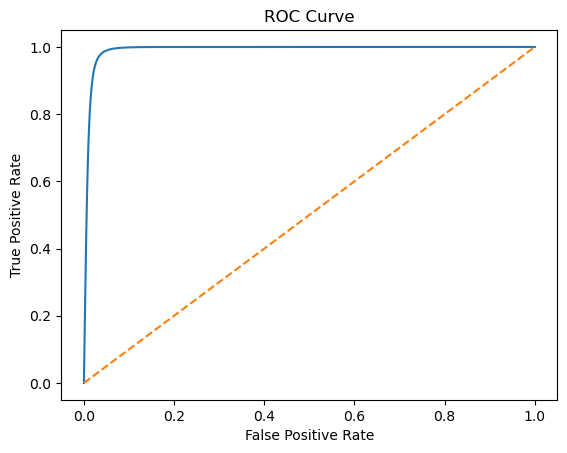

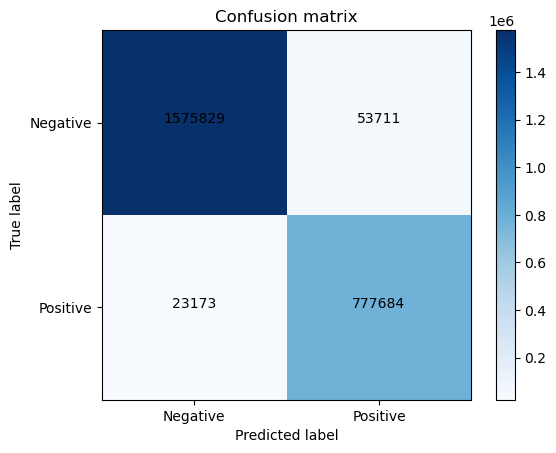

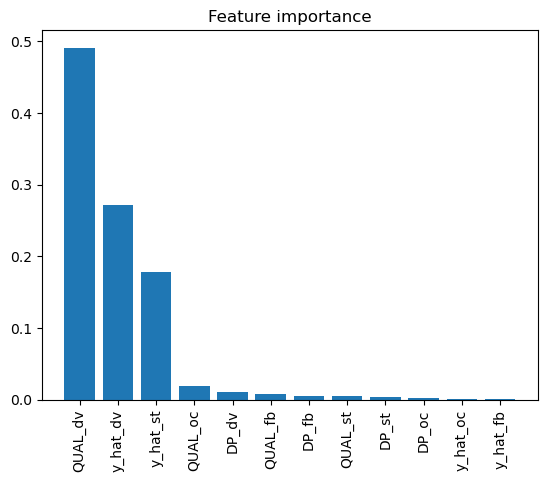

Training XGB_confident model for selection_confident data


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/3641173186.py:9: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Training set
y
True     3067083
False    2683371
Name: count, dtype: int64
Test set
y
True     766683
False    670931
Name: count, dtype: int64
Model XGB_confident already exists
Accuracy: 0.9957
Precision: 0.9937
Recall: 0.9983
F1: 0.9960
ROC AUC: 0.9984


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/1642315501.py:8: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Selecting based on index: 1437614 / 7143212
Calculating performance metrics for ['dv']
Selecting based on index: 1437614 / 3936789
Calculating performance metrics for ['fb']
Selecting based on index: 1437614 / 3898090
Calculating performance metrics for ['oc']
Selecting based on index: 1437614 / 3911090
Calculating performance metrics for ['st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['GXB']


True-pos-baseline  \
DATA                CALLER         METHOD   METRICS                      
selection_confident dv             None     custom              774288   
                    fb             None     custom              774288   
                    oc             None     custom              774288   
                    st             None     custom              774288   
                    dv, fb, oc, st all      custom              774288   
                                   majority custom              774288   
                                   any      custom              774288   
                                   XGB      custom              766683   

                                                     True-pos-call  False-pos  \
DATA                CALLER         METHOD   METRICS                             
selection_confident dv             None     custom          769522       5060   
                    fb             None     custom          753186      20695   
                    oc             None     custom          765761      10274   
                    st             None     custom          766960       6423   
                    dv, fb, oc, st all      custom          747011       3964   
                                   majority custom          767653       5211   
                                   any      custom          770827      25709   
                                   XGB      custom          765372       4876   

                                                     False-neg  Precision  \
DATA                CALLER         METHOD   METRICS                         
selection_confident dv             None     custom        4766     0.9935   
                    fb             None     custom       21102     0.9733   
                    oc             None     custom        8527     0.9868   
                    st             None     custom        7328     0.9917   
                    dv, fb, oc, st all      custom       27277     0.9947   
                                   majority custom        6635     0.9933   
                                   any      custom        3461     0.9677   
                                   XGB      custom        1311     0.9937   

                                                     Sensitivity  F-measure  
DATA                CALLER         METHOD   METRICS                          
selection_confident dv             None     custom        0.9938     0.9937  
                    fb             None     custom        0.9727     0.9730  
                    oc             None     custom        0.9890     0.9879  
                    st             None     custom        0.9905     0.9911  
                    dv, fb, oc, st all      custom        0.9648     0.9795  
                                   majority custom        0.9914     0.9923  
                                   any      custom        0.9955     0.9814  
                                   XGB      custom        0.9983     0.9960

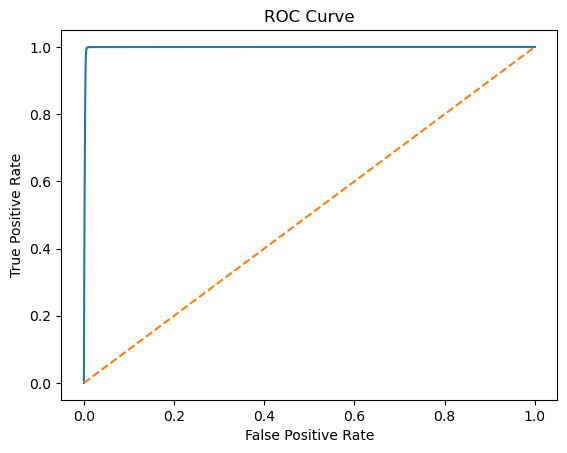

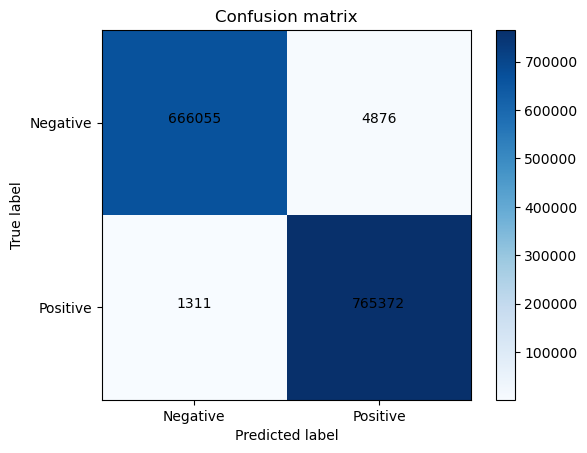

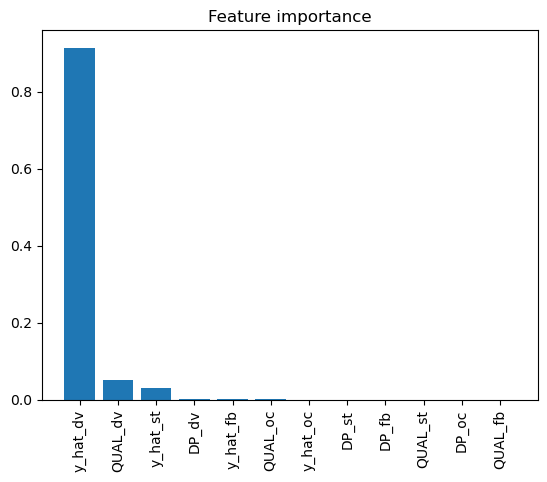

In [ ]:
clf_name = "XGB"

run_model(clf_name)

## Random Forest

Training RF model for selection data


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/3641173186.py:9: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Training set
y
False    6517242
True     3204344
Name: count, dtype: int64
Test set
y
False    1629540
True      800857
Name: count, dtype: int64
Model saved as src/models/RF.joblib
Accuracy: 0.9690
Precision: 0.9375
Recall: 0.9707
F1: 0.9538
ROC AUC: 0.9903


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/1642315501.py:8: DtypeWarning: Columns (22,23,24,25,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Selecting based on index: 2430397 / 11871797
Calculating performance metrics for ['dv']
Selecting based on index: 2430397 / 5168886
Calculating performance metrics for ['fb']
Selecting based on index: 2430397 / 4917529
Calculating performance metrics for ['oc']
Selecting based on index: 2430397 / 5138330
Calculating performance metrics for ['st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 2430397 / 12151983
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['GXB']


True-pos-baseline  True-pos-call  \
DATA      CALLER         METHOD   METRICS                                     
selection dv             None     custom              811228         804626   
          fb             None     custom              811228         784337   
          oc             None     custom              811228         799287   
          st             None     custom              811228         800216   
          dv, fb, oc, st all      custom              811228         775845   
                         majority custom              811228         800937   
                         any      custom              811228         806787   
                         XGB      custom              800857         777378   

                                           False-pos  False-neg  Precision  \
DATA      CALLER         METHOD   METRICS                                    
selection dv             None     custom      155164       6602     0.8383   
          fb             None     custom      239221      26891     0.7663   
          oc             None     custom      155453      11941     0.8372   
          st             None     custom      130728      11012     0.8596   
          dv, fb, oc, st all      custom       79440      35383     0.9071   
                         majority custom      121873      10291     0.8679   
                         any      custom      306900       4441     0.7244   
                         XGB      custom       51785      23479     0.9375   

                                           Sensitivity  F-measure  
DATA      CALLER         METHOD   METRICS                          
selection dv             None     custom        0.9919     0.9087  
          fb             None     custom        0.9669     0.8550  
          oc             None     custom        0.9853     0.9052  
          st             None     custom        0.9864     0.9186  
          dv, fb, oc, st all      custom        0.9564     0.9311  
                         majority custom        0.9873     0.9238  
                         any      custom        0.9945     0.8383  
                         XGB      custom        0.9707     0.9538

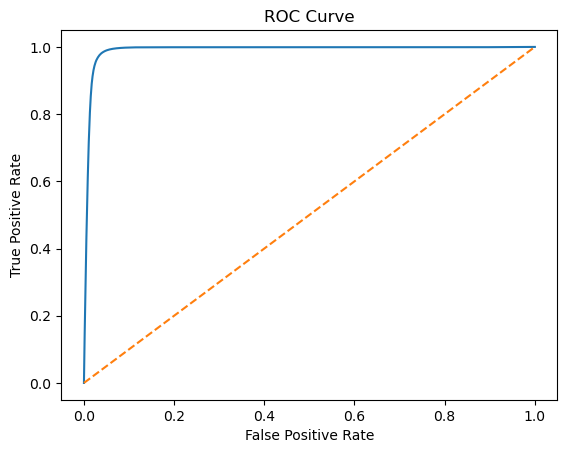

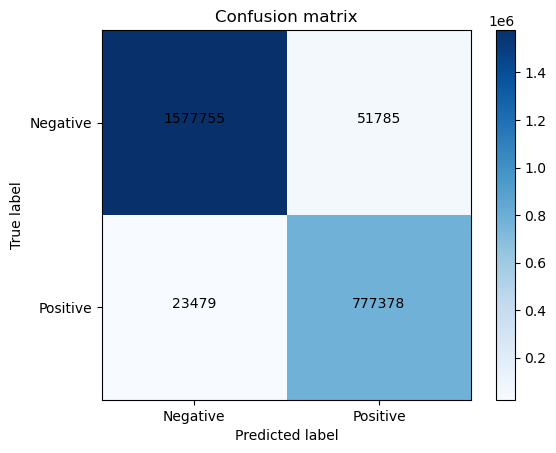

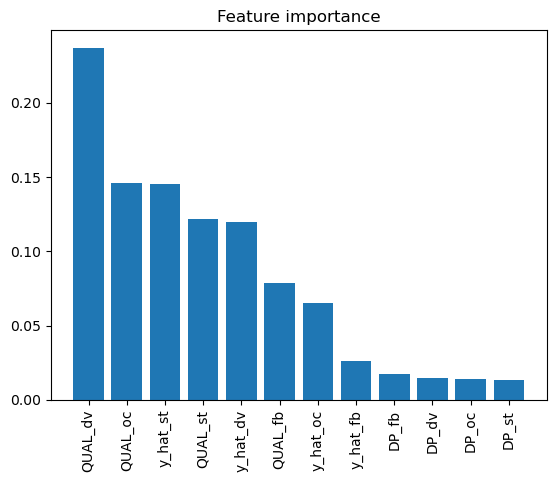

Training RF_confident model for selection_confident data


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/3641173186.py:9: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Training set
y
True     3067083
False    2683371
Name: count, dtype: int64
Test set
y
True     766683
False    670931
Name: count, dtype: int64
Model saved as src/models/RF_confident.joblib
Accuracy: 0.9958
Precision: 0.9937
Recall: 0.9985
F1: 0.9961
ROC AUC: 0.9980


/var/folders/9w/j1sly5qj0tsgk5xs7_1tlbz00000gn/T/ipykernel_74042/1642315501.py:8: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_VC_BM = pd.read_csv(PATH_PROCESSED + df_name + ".csv", dtype=DTYPE)


Selecting based on index: 1437614 / 7143212
Calculating performance metrics for ['dv']
Selecting based on index: 1437614 / 3936789
Calculating performance metrics for ['fb']
Selecting based on index: 1437614 / 3898090
Calculating performance metrics for ['oc']
Selecting based on index: 1437614 / 3911090
Calculating performance metrics for ['st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Selecting based on index: 1437614 / 7188068
Calculating performance metrics for ['dv', 'fb', 'oc', 'st']
Calculating performance metrics for ['GXB']


True-pos-baseline  \
DATA                CALLER         METHOD   METRICS                      
selection_confident dv             None     custom              774288   
                    fb             None     custom              774288   
                    oc             None     custom              774288   
                    st             None     custom              774288   
                    dv, fb, oc, st all      custom              774288   
                                   majority custom              774288   
                                   any      custom              774288   
                                   XGB      custom              766683   

                                                     True-pos-call  False-pos  \
DATA                CALLER         METHOD   METRICS                             
selection_confident dv             None     custom          769522       5060   
                    fb             None     custom          753186      20695   
                    oc             None     custom          765761      10274   
                    st             None     custom          766960       6423   
                    dv, fb, oc, st all      custom          747011       3964   
                                   majority custom          767653       5211   
                                   any      custom          770827      25709   
                                   XGB      custom          765536       4888   

                                                     False-neg  Precision  \
DATA                CALLER         METHOD   METRICS                         
selection_confident dv             None     custom        4766     0.9935   
                    fb             None     custom       21102     0.9733   
                    oc             None     custom        8527     0.9868   
                    st             None     custom        7328     0.9917   
                    dv, fb, oc, st all      custom       27277     0.9947   
                                   majority custom        6635     0.9933   
                                   any      custom        3461     0.9677   
                                   XGB      custom        1147     0.9937   

                                                     Sensitivity  F-measure  
DATA                CALLER         METHOD   METRICS                          
selection_confident dv             None     custom        0.9938     0.9937  
                    fb             None     custom        0.9727     0.9730  
                    oc             None     custom        0.9890     0.9879  
                    st             None     custom        0.9905     0.9911  
                    dv, fb, oc, st all      custom        0.9648     0.9795  
                                   majority custom        0.9914     0.9923  
                                   any      custom        0.9955     0.9814  
                                   XGB      custom        0.9985     0.9961

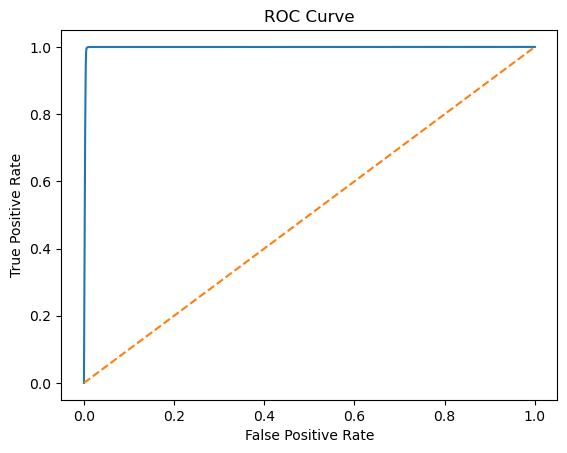

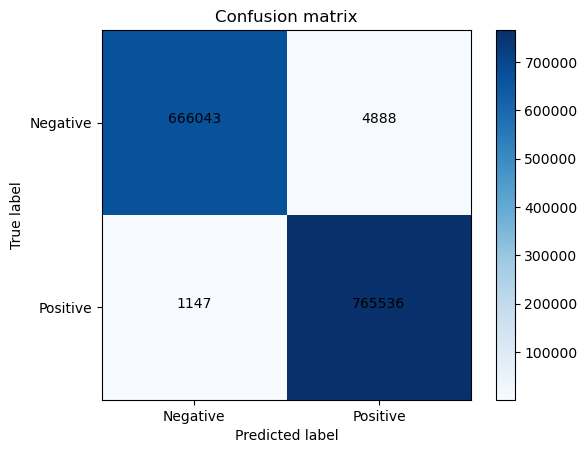

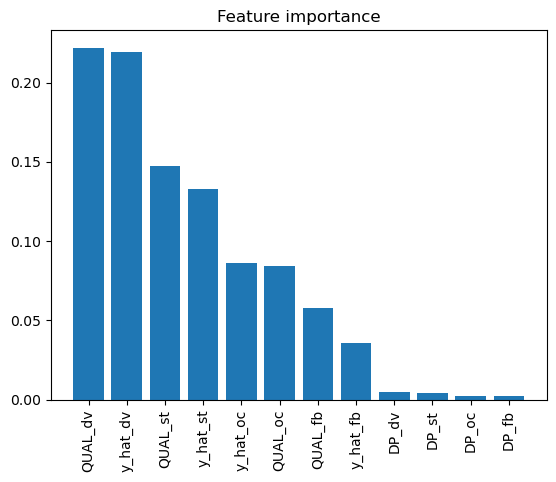

In [ ]:
clf_name = "RF"

run_model(clf_name)

------------------------------------------------------------------------------------------------

# Error analysis

## Type of errors

In [62]:
import gzip

# load the TP, FP, FN, TN indices from the vcfeval results
def load_vcfeval_lists(experiment: str, DIR_VCFEVAL: str, callers = CALLERS) -> dict:
    
        dict_vcfeval = {}
    
        for caller in CALLERS:
            for l in ["tp", "fn", "fp"]:
                file_name = f"{DIR_VCFEVAL}/vcfeval_{caller}_{experiment}/{l}.vcf.gz"
                # extract the gz file
                with gzip.open(file_name, "rb") as f:
                    with open(file_name[:-3], "wb") as f_out:
                        f_out.write(f.read())
                with open(file_name, "r") as file:
                    lines = file.readlines()
                    indices = [int(line.strip()) for line in lines]
                    dict_vcfeval[f"{l}_{caller}"] = indices

    
        return dict_vcfeval


# INDELS vs SNVs
def get_indels(df_VC_BM, conf = CONF, callers = [CALLERS[0]]):

    how = "per_caller"
    features=["REF", "ALT"]

    df_call = label_caller_data(df_VC_BM, conf, callers=callers, how=how, features=features)

    # label the indels and snvs
    indels_bool = df_call[f"REF_{callers[0]}"].str.len() != df_call[f"ALT_{callers[0]}"].str.len()
    snvs_bool = ~indels_bool

    df_call["variant"] = None
    df_call.loc[indels_bool, "variant"] = "indel"
    df_call.loc[snvs_bool, "variant"] = "snv"

    # label as TP, FP, FN, TN
    TP = (df_call["y"] & df_call[f"y_hat_{callers[0]}"])
    FP = (~df_call["y"] & df_call[f"y_hat_{callers[0]}"])
    FN = (df_call["y"] & ~df_call[f"y_hat_{callers[0]}"])
    TN = (~df_call["y"] & ~df_call[f"y_hat_{callers[0]}"])

    # save the indices of the indels and snvs, and the TP, FP, FN, TN
    indels = df_call[df_call["variant"] == "indel"].index
    snvs = df_call[df_call["variant"] == "snv"].index

    TP_index = df_call[TP].index
    FP_index = df_call[FP].index
    FN_index = df_call[FN].index
    TN_index = df_call[TN].index

    errors = {"TP": TP_index, "FP": FP_index, "FN": FN_index, "TN": TN_index, "indels": indels, "snvs": snvs}

    df_call["prediction"] = None
    df_call.loc[TP, "prediction"] = "TP"
    df_call.loc[FP, "prediction"] = "FP"
    df_call.loc[FN, "prediction"] = "FN"
    df_call.loc[TN, "prediction"] = "TN"


    # show value counts, also in percentage
    print(df_call[['prediction', 'variant']].value_counts())

    return df_call

## Locating the errors on the chromosome

In [10]:
PATH_PROCESSED

'data/processed/'

In [14]:
from utils.utils import read_vcf

experiment = "noinconsistent_withoutseq_qual"
for l in ["tp", "fn", "fp"]:
    file_name = f"{DIR_VCFEVAL}/vcfeval_dv_{experiment}/{l}.vcf.gz"
    t = read_vcf(file_name)

    # save to bed file: #chr \t start \t end
    t_bed = t[["CHROM", "POS"]].copy()
    t_bed["END"] = t_bed["POS"]

    t_bed["CHROM"] = "chr" + t_bed["CHROM"].astype(str)

    t_bed.to_csv(f"{PATH_PROCESSED}/vcfeval_dv_{experiment}_{l}.bed", sep="\t", header=True, index=False)


In [4]:
t

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,HG003_NA24149_Ashkenazim_father.trim
0,1,632644,.,A,G,20.3,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:20:49:32,17:0.346939:20,0,39"
1,1,633182,.,A,G,37.4,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:37:63:24,39:0.619048:37,0,52"
2,1,633209,.,T,C,23.9,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:24:57:22,35:0.614035:23,0,48"
3,1,633230,.,C,T,11.5,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:11:58:21,37:0.637931:11,0,47"
4,1,633251,.,C,T,11.6,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:12:57:19,38:0.666667:11,0,43"
...,...,...,...,...,...,...,...,...,...,...
5690,9,135419782,.,G,GGTTTTGTTTT,13.1,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:13:58:40,13:0.224138:12,0,39"
5691,9,135419803,.,TG,T,22.1,PASS,.,GT:GQ:DP:AD:VAF:PL,"0/1:22:49:33,13:0.265306:22,0,46"
5692,9,135632666,.,ATT,A,43.6,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:22:70:2,49:0.7:43,21,0"
5693,9,135781639,.,T,TAA,36.4,PASS,.,GT:GQ:DP:AD:VAF:PL,"1/1:3:56:12,37:0.660714:33,0,0"


In [2]:
import karyopype.karyopype as kp

# plot two sets of regions
kp.plot_karyopype("hg38", ["/data/raw/HG003_GRCh38_1_22_v4.2.1_benchmark_noinconsistent.bed"])

ImportError: cannot import name 'BrokenBarHCollection' from 'matplotlib.collections' (/Users/maartenbiolizard/mambaforge/envs/icr-variant_prediction/lib/python3.11/site-packages/matplotlib/collections.py)

In [1]:
%pip install karyopype

Note: you may need to restart the kernel to use updated packages.


In [63]:
df_call = get_indels(df_merged_BM)

prediction  variant
TN          snv        6394365
TP          snv        3389596
TN          indel       739289
TP          indel       582637
FP          snv         413559
            indel       319383
FN          indel        25082
            snv           7886
Name: count, dtype: int64


In [59]:
df_call

y_hat_dv      y REF_dv ALT_dv  indel    snv
CHROM POS                                                   
1     10120         False  False      T      C  False   True
      10126         False  False      T      C  False   True
      10132         False  False      T      C  False   True
      10138         False  False      T      C  False   True
      10146         False  False     AC      A   True  False
...                   ...    ...    ...    ...    ...    ...
9     138309970     False  False      T      G  False   True
      138309972     False  False      T      G  False   True
      138314183     False  False      T      C  False   True
      138315559     False  False      G      A  False   True
      138319163     False  False      T      G  False   True

[11871797 rows x 6 columns]

In [46]:
df_call.dropna(subset=["REF_BM", "ALT_BM"])

y_hat_dv     y REF_dv ALT_dv REF_BM ALT_BM
CHROM POS                                                  
1     602439        False  True    NaN    NaN      C      T
      602493        False  True    NaN    NaN      C      T
      602494        False  True    NaN    NaN      A      G
      631859         True  True     CG      C     CG      C
      779047         True  True      G      A      G      A
...                   ...   ...    ...    ...    ...    ...
9     138161156      True  True      G      A      G      A
      138163972      True  True      T      G      T      G
      138199834      True  True      C      G      C      G
      138201367      True  True      C      T      C      T
      138202773      True  True      A      G      A      G

[4031125 rows x 6 columns]